A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

As we did with linear regression, we can use nn.Linear to create the model instead of manually creating and initializing the matrices.

Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [9]:

# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data  import DataLoader

import torch.nn as nn

input_size =  28*28
num_classes = 10

#Logistic Regression Model
model =  nn.Linear(input_size, num_classes)

In [11]:
#Preparing Data
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

#Test_Data
test_dataset = MNIST(root='data/', train=False)

#Train and Validation Data
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

#Batch Data
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 147042615.08it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76522864.07it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29614320.08it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10619023.84it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Of course, this model is a lot larger than our previous model in terms of the number of parameters. Let's take a look at the weights and biases.

In [3]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0046, -0.0165, -0.0266,  ..., -0.0195,  0.0134, -0.0075],
        [-0.0297,  0.0141,  0.0266,  ...,  0.0039, -0.0261, -0.0341],
        [-0.0058, -0.0241,  0.0084,  ...,  0.0042,  0.0243,  0.0005],
        ...,
        [-0.0103, -0.0255,  0.0145,  ...,  0.0001,  0.0053, -0.0175],
        [ 0.0347, -0.0317,  0.0036,  ...,  0.0066,  0.0055, -0.0197],
        [ 0.0042, -0.0232,  0.0113,  ..., -0.0258, -0.0055,  0.0219]],
       requires_grad=True)

In [4]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0327, -0.0093,  0.0031, -0.0166,  0.0043, -0.0357,  0.0145,  0.0145,
        -0.0272, -0.0179], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [12]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([8, 5, 0, 9, 7, 7, 9, 8, 0, 2, 0, 9, 4, 1, 3, 4, 1, 4, 5, 9, 3, 4, 3, 5,
        2, 9, 9, 3, 9, 4, 3, 5, 4, 0, 4, 7, 1, 3, 7, 0, 1, 4, 1, 6, 6, 0, 6, 0,
        9, 8, 6, 6, 5, 2, 2, 3, 7, 6, 7, 9, 7, 8, 7, 9, 8, 4, 0, 5, 8, 1, 7, 6,
        8, 8, 7, 0, 8, 4, 1, 5, 1, 0, 2, 6, 2, 8, 4, 4, 2, 2, 9, 4, 7, 0, 1, 4,
        3, 6, 2, 4, 4, 3, 3, 5, 1, 5, 8, 0, 4, 6, 5, 4, 3, 9, 6, 3, 2, 6, 2, 7,
        2, 7, 3, 1, 1, 7, 0, 9])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [13]:
images.shape

torch.Size([128, 1, 28, 28])

In [14]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [15]:
class Person:
    # Class constructor
    def __init__(self, name, age):
        # Object properties
        self.name = name
        self.age = age

    # Method
    def say_hello(self):
        print("Hello my name is " + self.name + "!")

In [16]:
bob = Person("Bob", 32)

The object bob is an instance of the class Person.

We can access the object's properties (also called attributes) or invoke its methods using the . notation.

In [17]:
bob.name, bob.age

('Bob', 32)

In [18]:
bob.say_hello()

Hello my name is Bob!


In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [22]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [23]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0003, -0.0128,  0.0222,  ..., -0.0113, -0.0278,  0.0296],
         [-0.0042,  0.0082,  0.0119,  ..., -0.0082, -0.0252, -0.0352],
         [ 0.0141,  0.0180, -0.0273,  ..., -0.0355,  0.0101, -0.0148],
         ...,
         [ 0.0117, -0.0102, -0.0030,  ...,  0.0220,  0.0090, -0.0074],
         [-0.0084, -0.0256, -0.0328,  ...,  0.0147,  0.0003, -0.0098],
         [-0.0262,  0.0161,  0.0181,  ..., -0.0074, -0.0297,  0.0253]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0103,  0.0025,  0.0089, -0.0285, -0.0097,  0.0085, -0.0180, -0.0142,
          0.0319, -0.0107], requires_grad=True)]

In [24]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.2171, -0.0299,  0.0624, -0.1525, -0.2221, -0.0397, -0.0032,  0.2166,
         -0.0169,  0.1621],
        [ 0.1844,  0.0223,  0.1237, -0.1542, -0.2275,  0.1075,  0.1344,  0.1066,
          0.1674,  0.0307]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [25]:
import torch.nn.functional as F

The softmax function is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be ap

In [26]:
outputs[:2]

tensor([[-0.2171, -0.0299,  0.0624, -0.1525, -0.2221, -0.0397, -0.0032,  0.2166,
         -0.0169,  0.1621],
        [ 0.1844,  0.0223,  0.1237, -0.1542, -0.2275,  0.1075,  0.1344,  0.1066,
          0.1674,  0.0307]], grad_fn=<SliceBackward0>)

In [27]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0816, 0.0984, 0.1080, 0.0871, 0.0812, 0.0975, 0.1011, 0.1260, 0.0997,
         0.1193],
        [0.1135, 0.0965, 0.1068, 0.0809, 0.0752, 0.1051, 0.1080, 0.1050, 0.1116,
         0.0973]])
Sum:  0.9999998807907104


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [28]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([7, 0, 1, 1, 1, 1, 2, 6, 9, 5, 9, 9, 1, 6, 7, 2, 5, 1, 1, 1, 6, 1, 0, 7,
        7, 6, 1, 2, 1, 6, 2, 3, 8, 7, 8, 2, 5, 7, 9, 9, 9, 5, 9, 1, 1, 9, 7, 8,
        7, 9, 5, 1, 6, 8, 2, 1, 2, 8, 2, 6, 3, 2, 6, 9, 7, 7, 2, 7, 2, 7, 7, 2,
        1, 5, 0, 7, 5, 7, 7, 4, 7, 7, 0, 9, 1, 0, 1, 2, 7, 7, 7, 2, 6, 2, 7, 2,
        7, 5, 1, 9, 5, 1, 1, 1, 2, 2, 1, 9, 0, 9, 7, 1, 5, 8, 2, 1, 1, 7, 7, 7,
        7, 5, 7, 1, 7, 2, 7, 2])
tensor([0.1260, 0.1135, 0.1249, 0.1359, 0.1165, 0.1413, 0.1305, 0.1247, 0.1294,
        0.1133, 0.1223, 0.1298, 0.1179, 0.1297, 0.1189, 0.1433, 0.1321, 0.1313,
        0.1273, 0.1199, 0.1211, 0.1282, 0.1251, 0.1437, 0.1360, 0.1155, 0.1347,
        0.1268, 0.1271, 0.1240, 0.1279, 0.1150, 0.1221, 0.1086, 0.1216, 0.1187,
        0.1172, 0.1277, 0.1265, 0.1239, 0.1372, 0.1139, 0.1252, 0.1226, 0.1262,
        0.1366, 0.1196, 0.1258, 0.1504, 0.1351, 0.1238, 0.1129, 0.1207, 0.1172,
        0.1505, 0.1268, 0.1326, 0.1238, 0.1323, 0.1171, 0.1163, 0.1181, 0.1589,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [29]:
labels

tensor([9, 9, 5, 3, 9, 1, 6, 4, 2, 8, 4, 5, 0, 8, 5, 1, 9, 1, 3, 2, 6, 2, 9, 0,
        0, 0, 8, 1, 3, 3, 1, 4, 2, 3, 1, 3, 7, 2, 9, 6, 7, 4, 4, 2, 7, 5, 3, 4,
        9, 0, 4, 4, 0, 2, 6, 6, 1, 2, 8, 3, 9, 2, 6, 4, 2, 8, 7, 7, 1, 5, 4, 1,
        3, 9, 3, 8, 9, 8, 2, 7, 0, 4, 8, 4, 2, 8, 4, 9, 5, 2, 9, 6, 2, 1, 7, 1,
        9, 7, 3, 0, 1, 5, 3, 5, 7, 2, 1, 4, 3, 7, 5, 2, 4, 9, 6, 0, 0, 5, 7, 5,
        4, 1, 6, 3, 7, 1, 9, 6])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

# Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the accuracy of the predictions.

In [30]:
outputs[:2]

tensor([[-0.2171, -0.0299,  0.0624, -0.1525, -0.2221, -0.0397, -0.0032,  0.2166,
         -0.0169,  0.1621],
        [ 0.1844,  0.0223,  0.1237, -0.1542, -0.2275,  0.1075,  0.1344,  0.1066,
          0.1674,  0.0307]], grad_fn=<SliceBackward0>)

In [31]:
torch.sum(preds == labels)

tensor(12)

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [33]:
accuracy(outputs, labels)

tensor(0.0938)

In [34]:
probs

tensor([[0.0816, 0.0984, 0.1080,  ..., 0.1260, 0.0997, 0.1193],
        [0.1135, 0.0965, 0.1068,  ..., 0.1050, 0.1116, 0.0973],
        [0.1029, 0.1249, 0.1055,  ..., 0.1188, 0.0814, 0.1089],
        ...,
        [0.1002, 0.1070, 0.1094,  ..., 0.0865, 0.1080, 0.1008],
        [0.0745, 0.1212, 0.0974,  ..., 0.1384, 0.0942, 0.1191],
        [0.0853, 0.1027, 0.1320,  ..., 0.0971, 0.1189, 0.1116]],
       grad_fn=<SoftmaxBackward0>)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

3. For these reasons, accuracy is often used as an evaluation metric for classification, but not as a loss function. A commonly used loss function for classification problems is the cross-entropy, which has the following formula:



Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [35]:
loss_fn = F.cross_entropy

In [36]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3282, grad_fn=<NllLossBackward0>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

# Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class.

In [37]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results

    for epoch in range(epochs):

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the evaluate function, used in the validation phase of fit.

In [38]:
l1 = [1, 2, 3, 4, 5]

l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [39]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [40]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

In [41]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.295954942703247, 'val_acc': 0.1539754718542099}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [42]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9286, val_acc: 0.6273
Epoch [1], val_loss: 1.6633, val_acc: 0.7272
Epoch [2], val_loss: 1.4655, val_acc: 0.7607
Epoch [3], val_loss: 1.3159, val_acc: 0.7830
Epoch [4], val_loss: 1.2009, val_acc: 0.7985


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs. Try changing the learning rates and number of epochs in each of the cells below.

In [43]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1105, val_acc: 0.8087
Epoch [1], val_loss: 1.0378, val_acc: 0.8168
Epoch [2], val_loss: 0.9783, val_acc: 0.8222
Epoch [3], val_loss: 0.9288, val_acc: 0.8266
Epoch [4], val_loss: 0.8869, val_acc: 0.8299


In [44]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8510, val_acc: 0.8335
Epoch [1], val_loss: 0.8199, val_acc: 0.8372
Epoch [2], val_loss: 0.7926, val_acc: 0.8398
Epoch [3], val_loss: 0.7685, val_acc: 0.8423
Epoch [4], val_loss: 0.7470, val_acc: 0.8448


In [45]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7278, val_acc: 0.8475
Epoch [1], val_loss: 0.7105, val_acc: 0.8489
Epoch [2], val_loss: 0.6947, val_acc: 0.8507
Epoch [3], val_loss: 0.6803, val_acc: 0.8529
Epoch [4], val_loss: 0.6671, val_acc: 0.8538


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

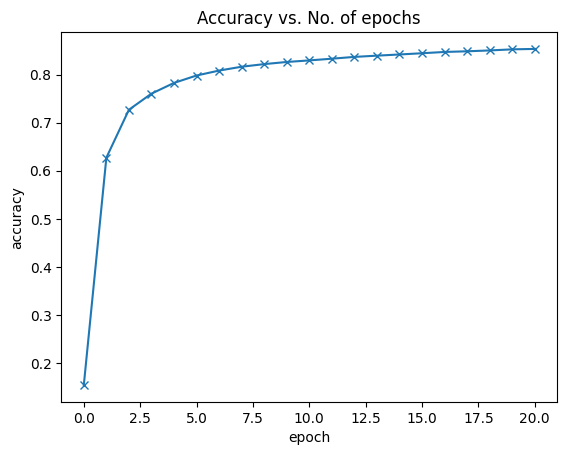

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [48]:
#Saving and loading the model
torch.save(model.state_dict(), 'mnist-logistic.pth')

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [49]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0055, -0.0196, -0.0026,  ..., -0.0111, -0.0052,  0.0274],
                      [ 0.0258,  0.0302,  0.0353,  ...,  0.0060, -0.0309,  0.0104],
                      [ 0.0224, -0.0062, -0.0047,  ..., -0.0207,  0.0324,  0.0082],
                      ...,
                      [ 0.0002, -0.0190,  0.0111,  ..., -0.0072, -0.0255, -0.0025],
                      [ 0.0008, -0.0096, -0.0252,  ...,  0.0112,  0.0240, -0.0269],
                      [-0.0074, -0.0211, -0.0228,  ...,  0.0217,  0.0219, -0.0272]])),
             ('linear.bias',
              tensor([-0.0434,  0.0937, -0.0471, -0.0041,  0.0417,  0.0416, -0.0067,  0.0731,
                      -0.1013, -0.0212]))])

To load the model weights, we can instante a new object of the class MnistModel, and use the .load_state_dict method.

In [50]:
model2 = MnistModel()

In [51]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0174,  0.0225, -0.0011,  ..., -0.0054, -0.0149, -0.0218],
                      [ 0.0073, -0.0297,  0.0340,  ...,  0.0308,  0.0344,  0.0057],
                      [-0.0286,  0.0070, -0.0280,  ...,  0.0264,  0.0217, -0.0238],
                      ...,
                      [ 0.0011,  0.0133,  0.0107,  ...,  0.0158,  0.0090,  0.0323],
                      [-0.0355, -0.0222,  0.0106,  ...,  0.0203,  0.0156,  0.0286],
                      [-0.0146, -0.0101,  0.0013,  ...,  0.0327, -0.0211, -0.0119]])),
             ('linear.bias',
              tensor([-0.0148, -0.0059, -0.0263, -0.0031,  0.0257,  0.0218, -0.0260, -0.0230,
                       0.0232,  0.0127]))])

In [52]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0055, -0.0196, -0.0026,  ..., -0.0111, -0.0052,  0.0274],
                      [ 0.0258,  0.0302,  0.0353,  ...,  0.0060, -0.0309,  0.0104],
                      [ 0.0224, -0.0062, -0.0047,  ..., -0.0207,  0.0324,  0.0082],
                      ...,
                      [ 0.0002, -0.0190,  0.0111,  ..., -0.0072, -0.0255, -0.0025],
                      [ 0.0008, -0.0096, -0.0252,  ...,  0.0112,  0.0240, -0.0269],
                      [-0.0074, -0.0211, -0.0228,  ...,  0.0217,  0.0219, -0.0272]])),
             ('linear.bias',
              tensor([-0.0434,  0.0937, -0.0471, -0.0041,  0.0417,  0.0416, -0.0067,  0.0731,
                      -0.1013, -0.0212]))])